In [ ]:
#Прошу еще 2 дня на доделать!

In [17]:
import json
import re
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [19]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:02, 1640.61it/s]


In [23]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [25]:
'''Посчитайте количество отзывов в разных городах и на разные банки'''

'Посчитайте количество отзывов в разных городах и на разные банки'

In [27]:
counter = {}
for resp in responses:
    if resp['city'] in counter:
        counter[resp['city']] += 1
    else:
        counter[resp['city']] = 1

In [28]:
counter

{'г. Москва': 55354,
 'г. Новосибирск': 2300,
 'г. Ставрополь': 696,
 'г. Челябинск': 1507,
 'г. Волгоград': 1014,
 'г. Пермь': 1163,
 'г. Ростов-на-Дону': 1891,
 'г. Воронеж': 1210,
 'г. Таганрог (Ростовская обл.)': 8,
 'г. Санкт-Петербург': 14342,
 'г. Конаково': 9,
 'г. Мурманск': 434,
 'г. Волгодонск (Ростовская обл.)': 7,
 'г. Большеречье': 2,
 'г. Одинцово (Московская обл.)': 8,
 'г. Салават (Республика Башкортостан)': 4,
 'г. Краснодар': 1262,
 'г. Кострома': 160,
 'г. Нижний Новгород': 1976,
 'г. Орел': 234,
 'г. Саратов': 933,
 'г. Казань': 1440,
 'г. Реутов (Московская обл.)': 3,
 'г. Ульяновск': 500,
 'г. Красноярск': 1236,
 'г. Хабаровск': 681,
 'г. Магнитогорск (Челябинская обл.)': 16,
 'г. Фролово (Волгоградская обл.)': 1,
 'г. Новочеркасск': 67,
 'г. Чита': 126,
 'г. таганрог': 8,
 'г. Йошкар-Ола': 190,
 'г. Нижний Тагил': 189,
 'г. Ханты-Мансийск': 48,
 'г. Россия': 204,
 'г. Липецк': 461,
 'г. Нижнекамск (Республика Татарстан)': 5,
 'г. Тюмень': 656,
 'г. Москва, Санкт

In [29]:
'''Постройте гистограмы длин слов в символах и в словах'''

'Постройте гистограмы длин слов в символах и в словах'

In [30]:
df = pd.DataFrame()

lens = []
symbols = []
texts = []
for resp in responses:
    symbols.append(len(resp['text']))
    lens.append(len(resp['text'].split(' ')))
    texts.append(resp['text'])

grades = []
for resp in responses:
    grades.append(resp['rating_grade'])

df['lens'] = lens
df['symbols'] = symbols
df['texts'] = texts
df['grades'] = grades

In [31]:
#гистограма длин слов в словах

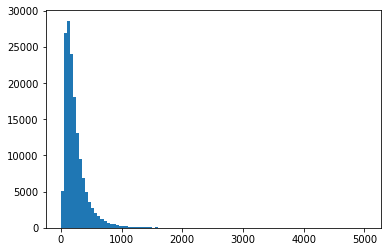

In [32]:
a = plt.hist(df.lens, bins = 100)

In [33]:
#гистограма длин слов в символах

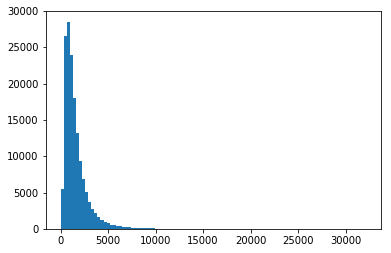

In [34]:
b = plt.hist(df.symbols, bins = 100)

In [35]:
'''Найдите 10 самых частых:слов'''

'Найдите 10 самых частых:слов'

In [36]:
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df.texts = df.texts.str.lower()
df.texts = df.texts.apply(words_only)

In [37]:
from nltk import FreqDist
n_types = []
n_tokens = []
tokens = []
fd = FreqDist()
for index, row in df.iterrows():
    tokens = row['texts'].split()
    fd.update(tokens)
    n_types.append(len(fd))
    n_tokens.append(sum(fd.values()))
for i in fd.most_common(10):
    print(i)

('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


In [38]:
'''Найдите 10 самых частых:слов без стоп-слов'''

'Найдите 10 самых частых:слов без стоп-слов'

In [39]:
from nltk.corpus import stopwords

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def lemmatize(text):
    m = MorphAnalyzer()
    try:
        lemmas1 = [m.parse(word)[0].normal_form for word in text.split()]
        return ' '.join(lemmas1) 
    except:
        return " "

mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [40]:
df['no_stopw'] = df['texts'].apply(remove_stopwords)

In [41]:
from nltk import FreqDist
n_types = []
n_tokens = []
tokens = []
fd = FreqDist()
for index, row in df.iterrows():
    tokens = row['no_stopw'].split()
    fd.update(tokens)
    n_types.append(len(fd))
    n_tokens.append(sum(fd.values()))
for i in fd.most_common(10):
    print(i)

('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


In [43]:
'''Найдите 10 самых частых:лемм'''

'Найдите 10 самых частых:лемм'

In [44]:
from pymorphy2 import MorphAnalyzer

In [47]:
from wordcloud import WordCloud

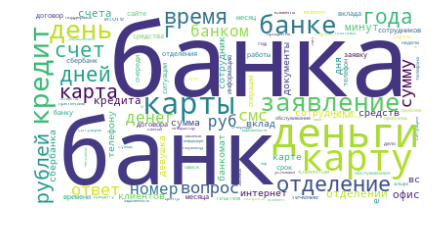

In [48]:
#top существительных
ma = MorphAnalyzer()
word_freq = []
for i in fd.most_common(200):
    p = ma.parse(i[0])[0].tag
    if {'NOUN'} in p:
        word_freq.append(i)
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure(figsize=(7,4))
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas('PROGRESS>>>')
df['text_lemmatize'] = df['no_stopw'].progress_apply(lemmatize)

In [ ]:
lemm = []
for i in df.no_stopw:
    lemm.append(lemmatize(i))

In [ ]:
'''Постройте кривые Ципфа и Хипса'''

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

In [ ]:
freqs = list(fd.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()